# 1. Introduction:

### **Real-Time Phishing Website Detection Using Machine Learning**
This project aims to develop a real-time machine learning model for detecting phishing websites based on URL structure and website metadata. By leveraging a range of features extracted from hyperlinks, domain properties, and web content indicators, our model helps security systems and web platforms proactively classify websites as either phishing or legitimate. This approach is designed to strengthen user protection against cyber threats by identifying malicious sites before users interact with them.

The *Web Page Phishing Detection Dataset*$\text{}^{1}$ consists of 11,430 labeled web URLs collected from the Kaggle repository and introduced in the study by Hannousse & Yahiouche (2021). Each instance contains 87 features derived from both the structure of the URL and the behavior or layout of the website itself. These attributes include syntactic patterns, domain reputation signals, and HTML/JavaScript behaviors commonly associated with phishing attempts.

# 2. Library Imports 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Functions

In [6]:
def plot_features(df, features, title):
    # set the number of columns per row
    n_cols = 4
    n_rows = (len(features) + n_cols - 1) // n_cols  # auto-adjust rows
    
    # create subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 3))
    axes = axes.flatten()
    
    # plot histograms using seaborn
    for i, feature in enumerate(features):
        sns.histplot(data=df, x=feature, ax=axes[i], bins=20, kde=False, edgecolor='black')
        axes[i].set_title(feature)
        axes[i].set_xlabel("value")
        axes[i].set_ylabel("frequency")
    
    # remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # set overall title and layout
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


# 3. Data Loading and Initial Overview
In this section, we load the dataset and perform initial data exploration.

In [8]:
df_raw = pd.read_csv("data/dataset_phishing.csv")
df_raw.head() # check the first few rows of our data

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [9]:
# get shape of data set, data types and non-null count
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

# 4. Exploratory Data Analysis (EDA)
In this section, we analyze the data statistical analysis and visualizations to uncover trends and relationships between variables. Given the large number of features (80+), we organize them into categories based on the type and origin of the information they represent

### URL Structure Features
- `length_url`: Total number of characters in the URL.
- `length_hostname`: Length of the domain/host portion.
- `ip`: 1 if IP address is used in URL, 0 if domain name.
- `nb_dots`: Number of dots (`.`) in the URL.
- `nb_hyphens`: Number of hyphens (`-`) in the URL.
- `nb_at`: Number of at symbols (`@`) in the URL.
- `nb_qm`: Number of question marks (`?`) in the URL.
- `nb_and`: Number of ampersands (`&`) in the URL.
- `nb_or`: Number of pipe symbols (`|`) in the URL.
- `nb_eq`: Number of equal signs (`=`) in the URL.
- `nb_underscore`: Number of underscores (`_`).
- `nb_tilde`: Number of tildes (`~`).
- `nb_percent`: Number of percent signs (`%`).
- `nb_slash`: Number of slashes (`/`).
- `nb_star`: Number of asterisks (`*`).
- `nb_colon`: Number of colons (`:`).
- `nb_comma`: Number of commas (`,`).
- `nb_semicolumn`: Number of semicolons (`;`).
- `nb_dollar`: Number of dollar signs (`$`).
- `nb_space`: Number of spaces.
- `nb_www`: Occurrences of “www” in the URL.
- `nb_com`: Occurrences of “.com” in the URL.
- `nb_dslash`: Double slashes (`//`) beyond the protocol.
- `http_in_path`: Occurrences of “http” in the URL
- `https_token`: 1 if “https” is used deceptively in the path or subdomain.

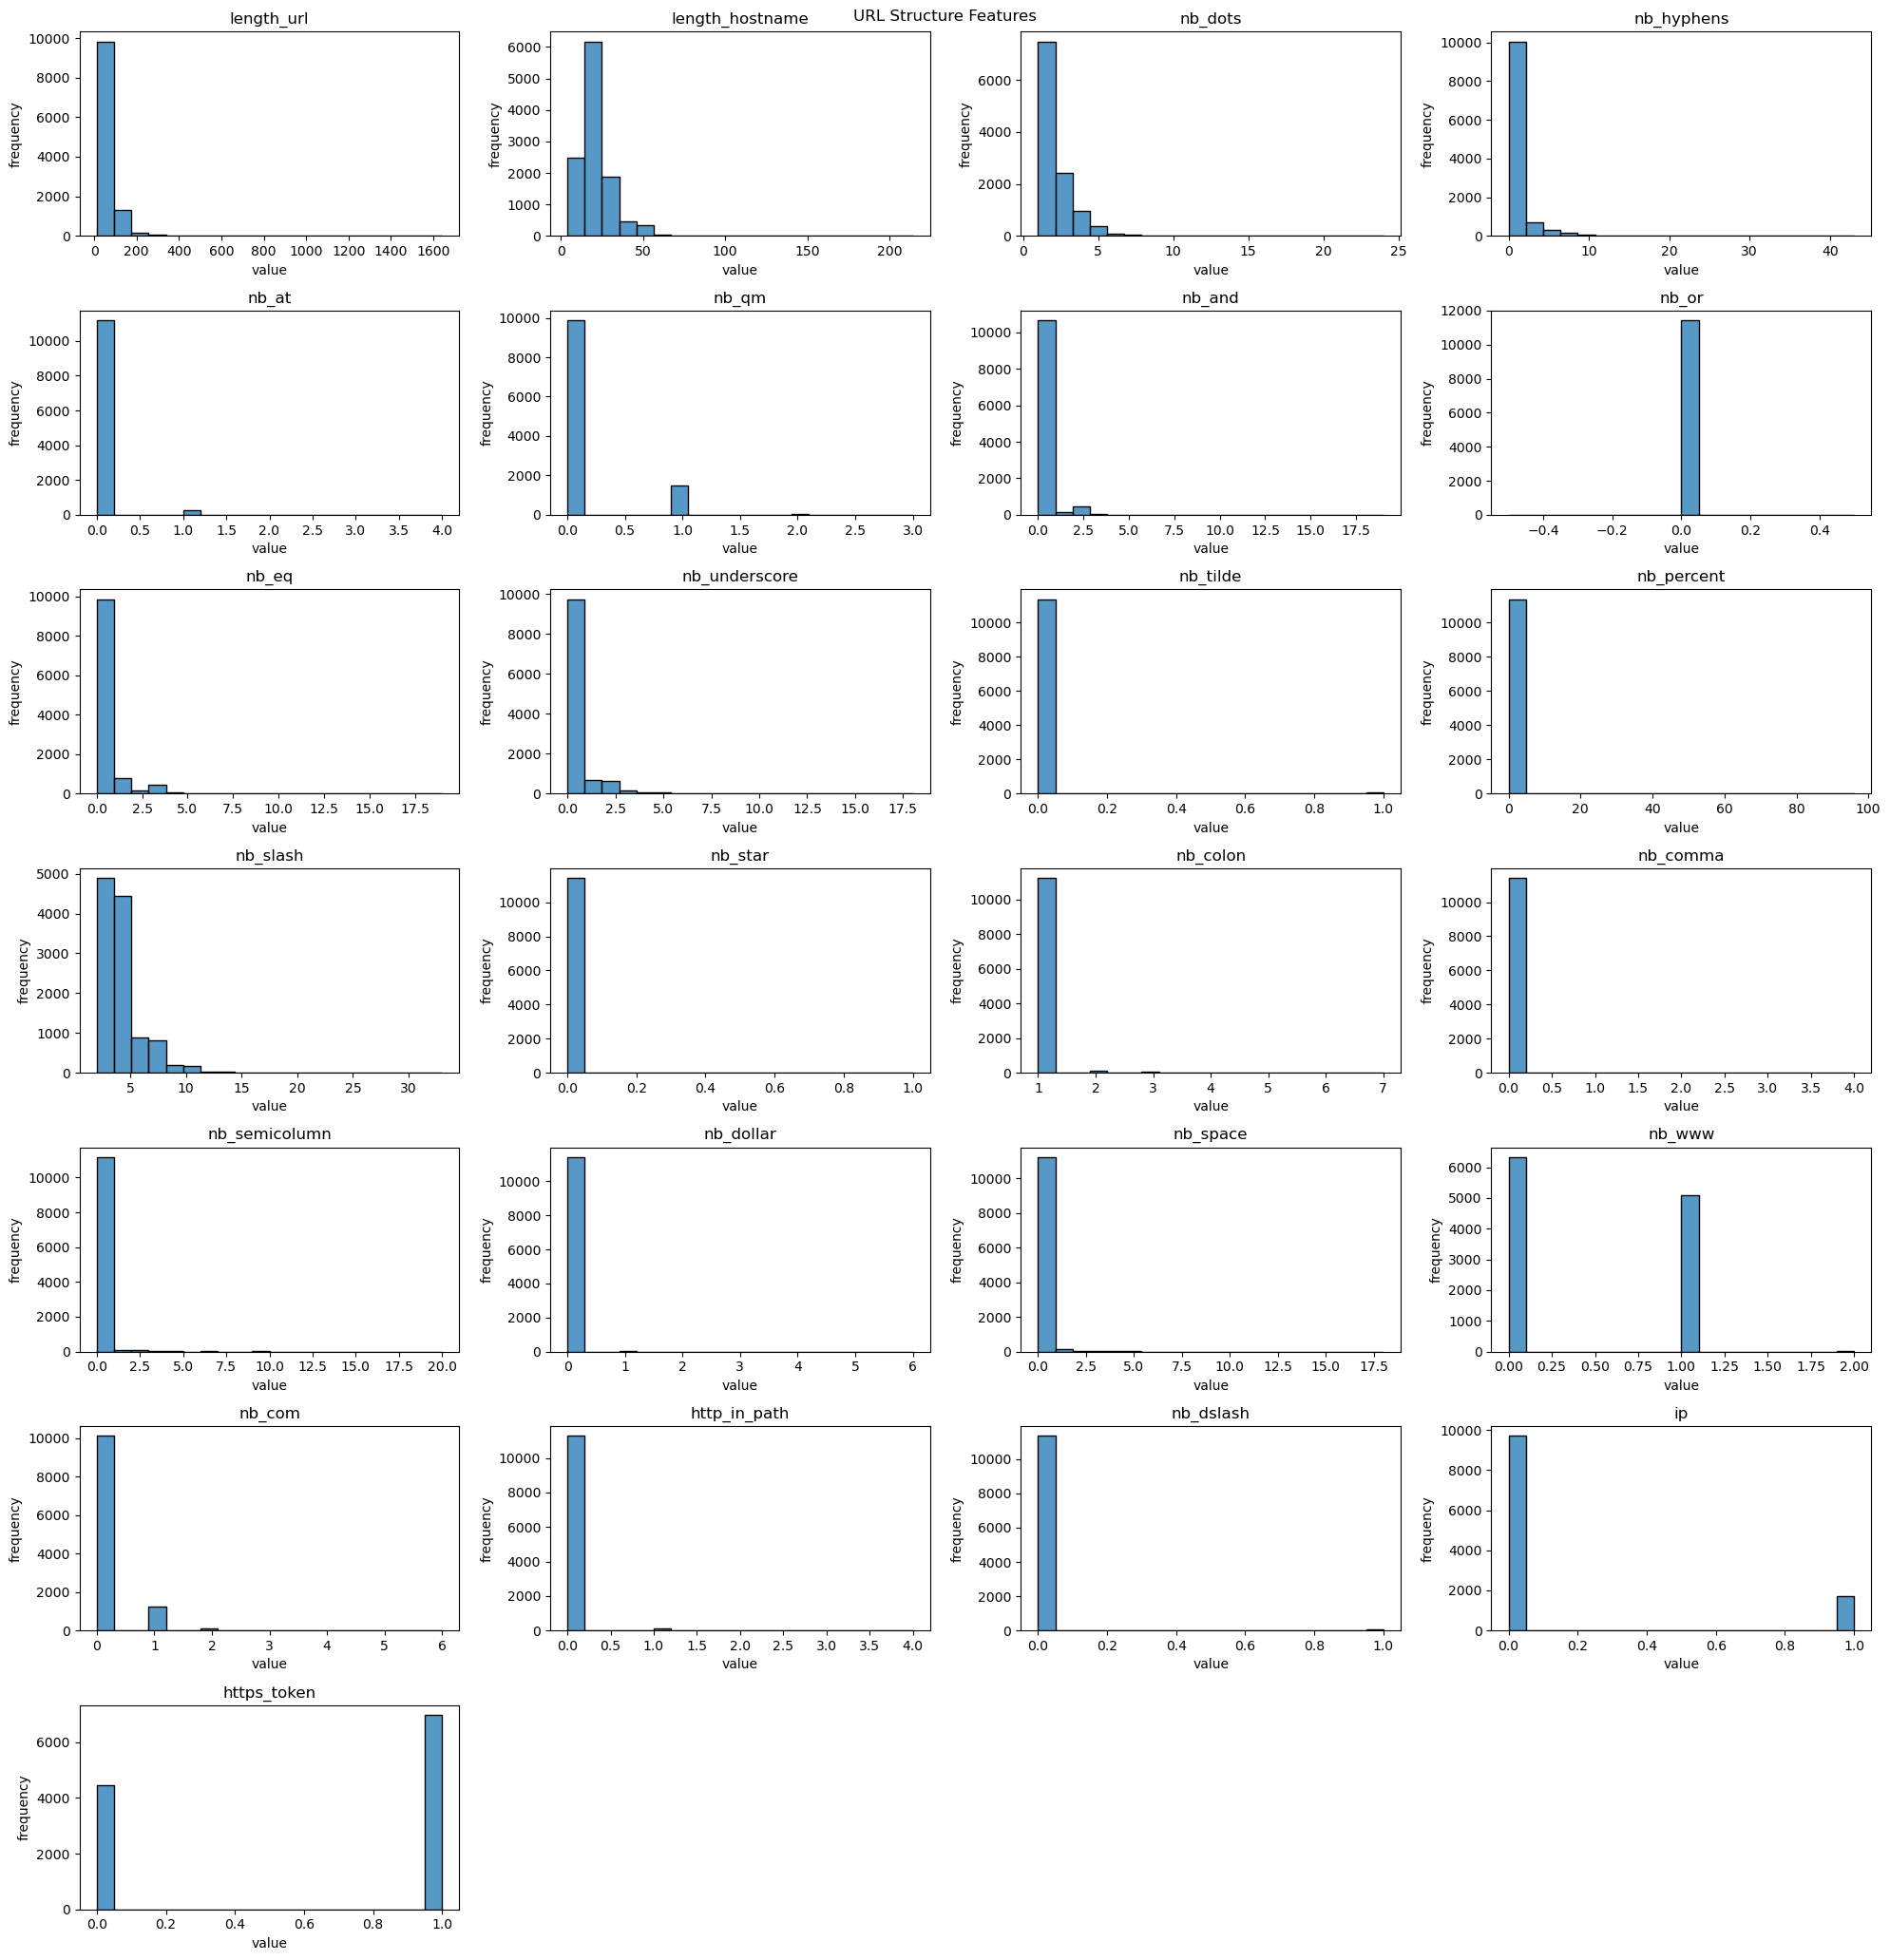

In [12]:
# selected feature 
url_structure_features = [
    'length_url',
    'length_hostname',
    'nb_dots',
    'nb_hyphens',
    'nb_at',
    'nb_qm',
    'nb_and',
    'nb_or',
    'nb_eq',
    'nb_underscore',
    'nb_tilde',
    'nb_percent',
    'nb_slash',
    'nb_star',
    'nb_colon',
    'nb_comma',
    'nb_semicolumn',
    'nb_dollar',
    'nb_space',
    'nb_www',
    'nb_com',
    'http_in_path',
    'nb_dslash',
    'ip',
    'https_token'
]

# plot features
plot_features(df_raw, url_structure_features, "URL Structure Features")

### Character Ratio Features
- `ratio_digits_url`: Ratio of numeric characters in URL.
- `ratio_digits_host`: Ratio of numeric characters in the domain name.

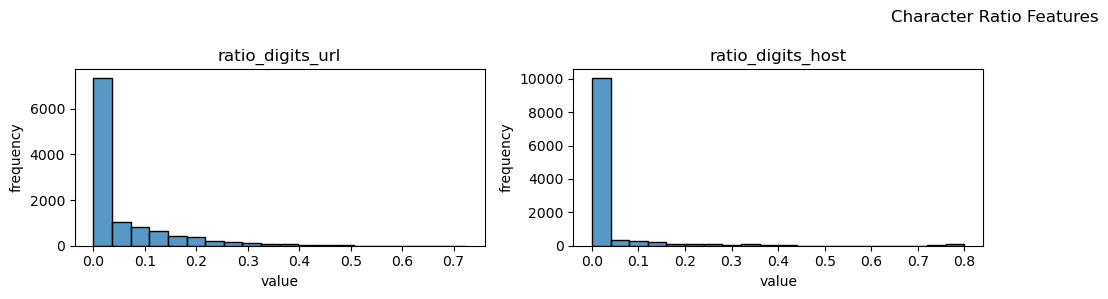

In [14]:
character_ratio_features = [
    'ratio_digits_url',
    'ratio_digits_host'
]

plot_features(df_raw, character_ratio_features, "Character Ratio Features")

### Domain Features
- `punycode`: 1 if domain uses punycode (non-ASCII domain).
- `port`: Port number used.
- `tld_in_path`: 1 if top-level domain appears in the path.
- `tld_in_subdomain`: 1 if TLD is in the subdomain.
- `abnormal_subdomain`: 1 if subdomain appears unusual or suspicious.
- `nb_subdomains`: Number of subdomains in the URL.
- `prefix_suffix`: 1 if a hyphen separates parts of the domain.
- `random_domain`: 1 if domain is likely randomly generated.
- `shortening_service`: 1 if a URL shortener is used.

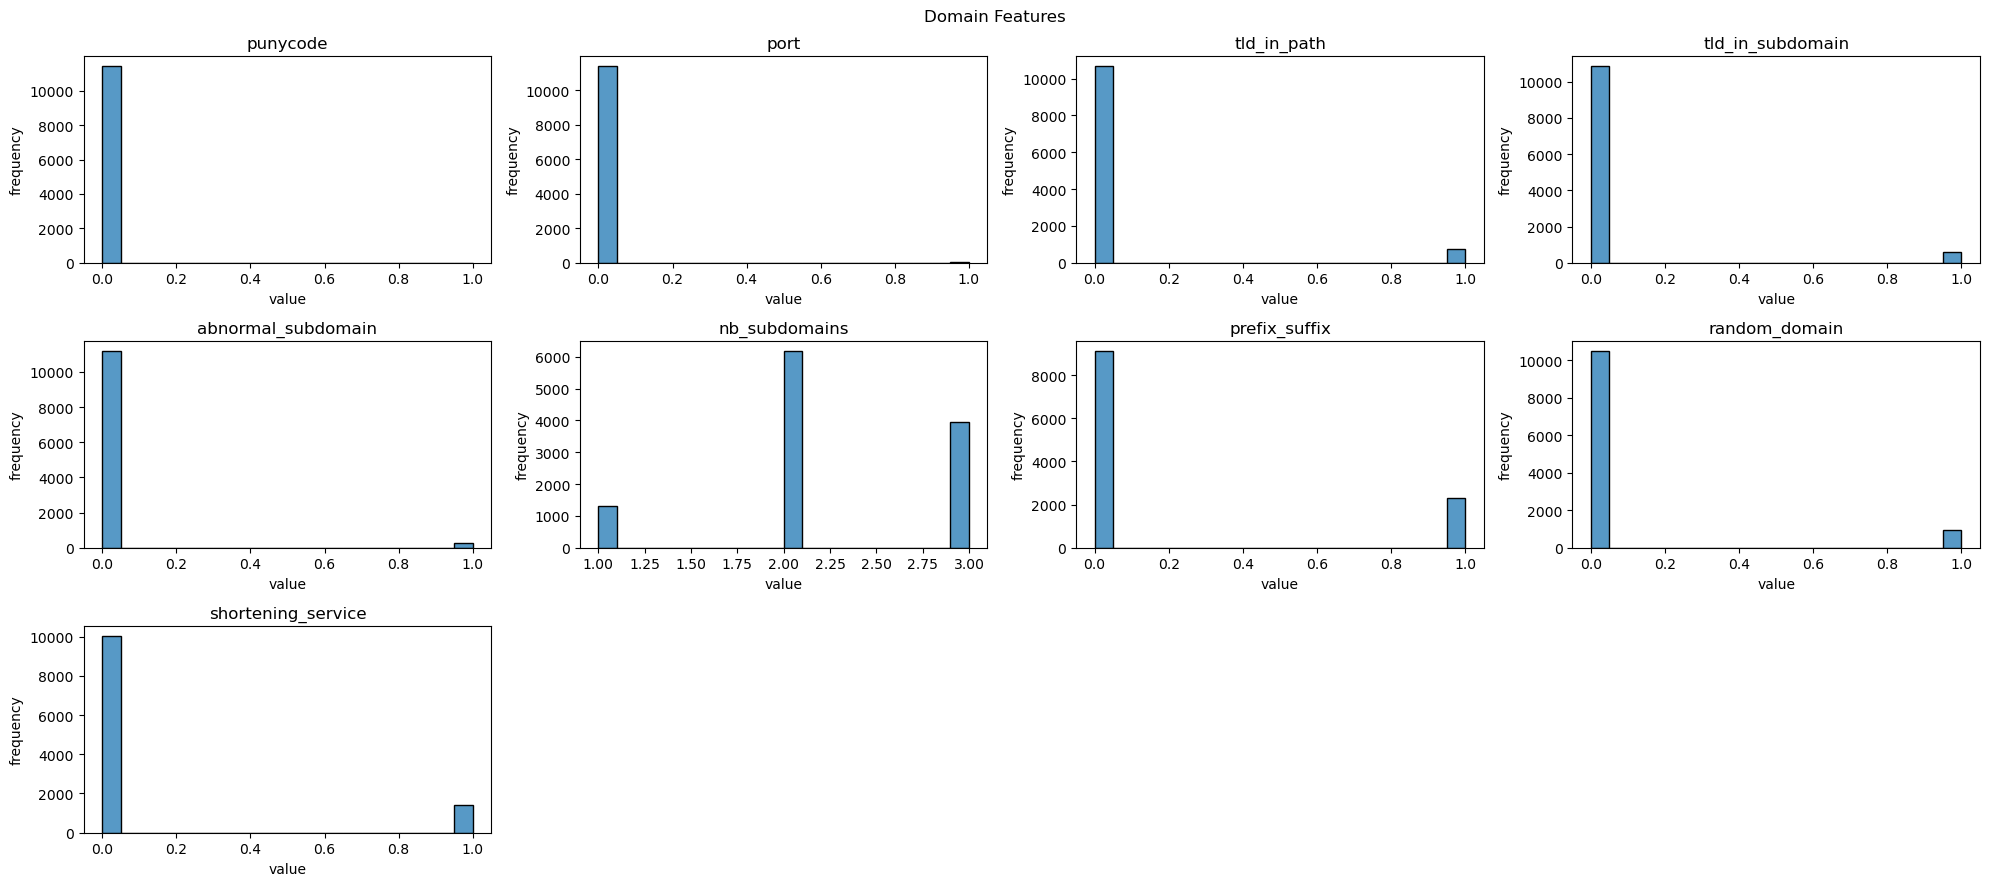

In [16]:
domain_features = [
    'punycode',
    'port',
    'tld_in_path',
    'tld_in_subdomain',
    'abnormal_subdomain',
    'nb_subdomains',
    'prefix_suffix',
    'random_domain',
    'shortening_service'
]

plot_features(df_raw, domain_features, "Domain Features")

### Text Analysis Features
- `length_words_raw`: Total character length of all words in the URL.
- `char_repeat`: Repeated characters (e.g., “aaaa”).
- `shortest_words_raw`: Length of the shortest word in the URL.
- `shortest_word_host`: Length of the shortest word in the hostname.
- `shortest_word_path`: Length of the shortest word in the path.
- `longest_words_raw`: Length of the longest word in the URL.
- `longest_word_host`: Longest word in the host.
- `longest_word_path`: Longest word in the path.
- `avg_words_raw`: Average word length in the full URL.
- `avg_word_host`: Average word length in the host.
- `avg_word_path`: Average word length in the path.

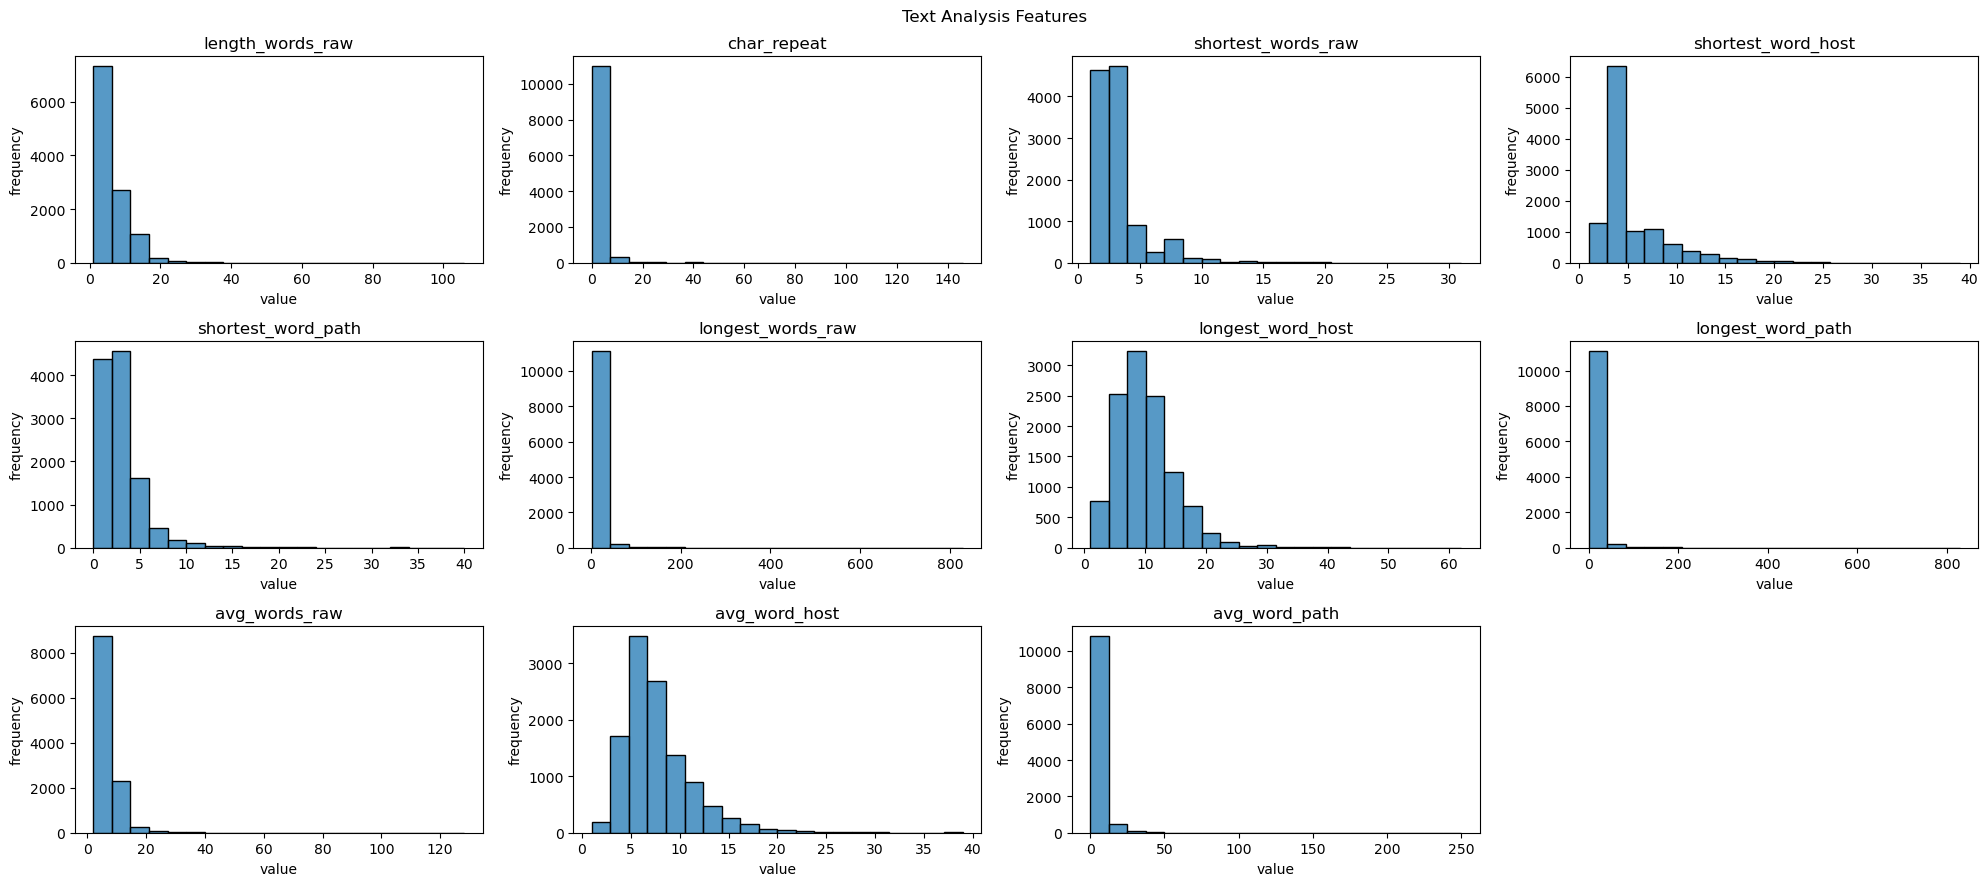

In [18]:
text_analysis_features = [
    'length_words_raw',
    'char_repeat',
    'shortest_words_raw',
    'shortest_word_host',
    'shortest_word_path',
    'longest_words_raw',
    'longest_word_host',
    'longest_word_path',
    'avg_words_raw',
    'avg_word_host',
    'avg_word_path'
]

plot_features(df_raw, text_analysis_features, "Text Analysis Features")

### Heuristic Features
- `phish_hints`: Count of phishing-related words in the URL.
- `domain_in_brand`: 1 if domain name is part of a known brand.
- `brand_in_subdomain`: 1 if brand name is in the subdomain.
- `brand_in_path`: 1 if brand name appears in the path.
- `suspecious_tld`: 1 if TLD is commonly used in phishing.
- `statistical_report`: 1 if flagged in threat intelligence sources.

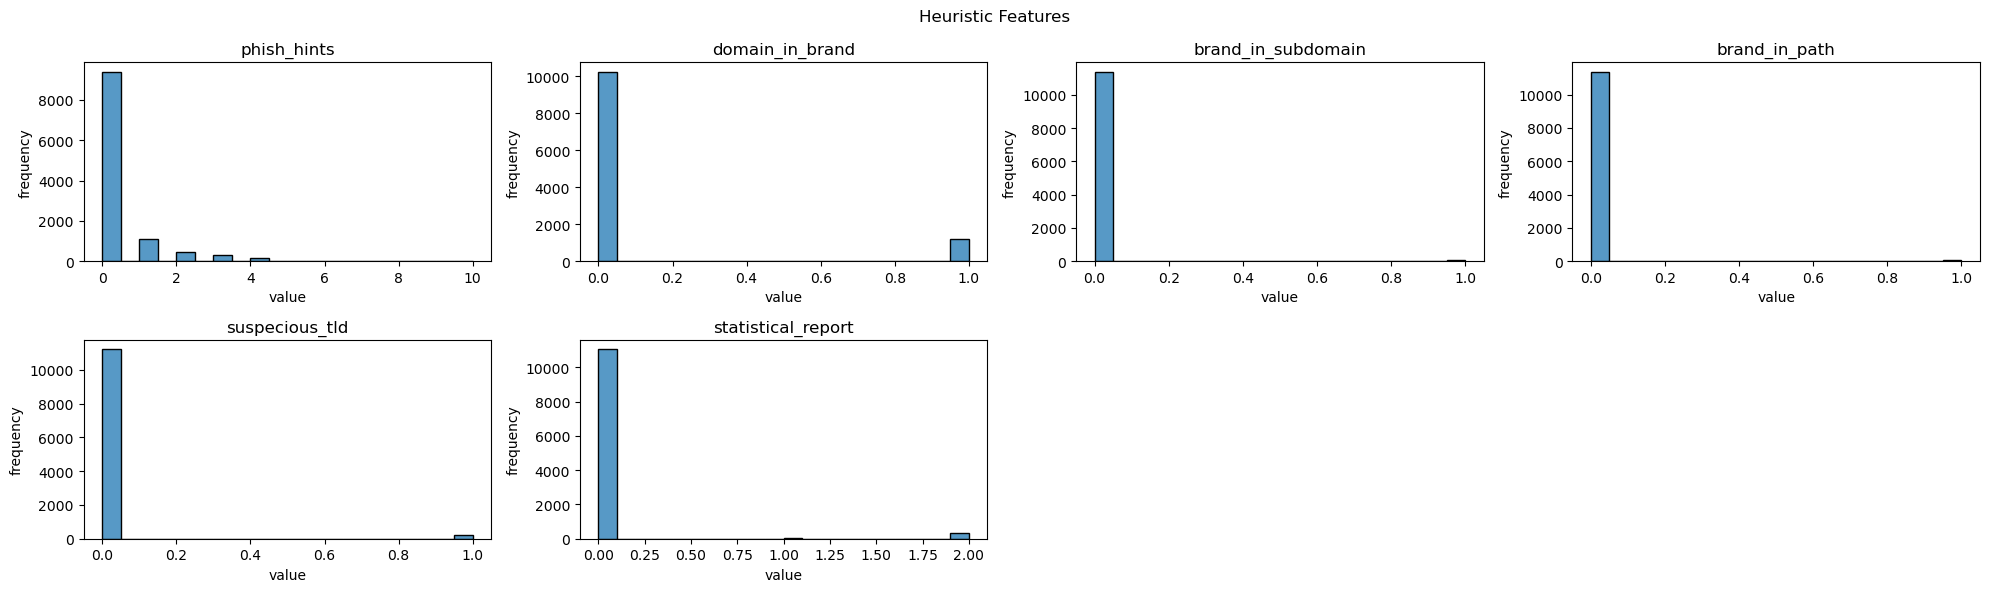

In [20]:
heuristic_features = [
    'phish_hints',
    'domain_in_brand',
    'brand_in_subdomain',
    'brand_in_path',
    'suspecious_tld',
    'statistical_report'
]

plot_features(df_raw, heuristic_features, "Heuristic Features")

### HTML & JavaScript Features
- `nb_hyperlinks`: Number of hyperlinks on the page.
- `ratio_intHyperlinks`: Ratio of internal links.
- `ratio_extHyperlinks`: Ratio of external links.
- `ratio_nullHyperlinks`: Ratio of null/empty links.
- `nb_extCSS`: Number of external CSS files used.
- `ratio_intRedirection`: Ratio of internal redirection links.
- `ratio_extRedirection`: Ratio of external redirection links.
- `ratio_intErrors`: Ratio of broken internal links.
- `ratio_extErrors`: Ratio of broken external links.
- `login_form`: 1 if a login form is detected.
- `external_favicon`: 1 if favicon is loaded from a third-party site.
- `links_in_tags`: Ratio of links embedded in HTML tags.
- `submit_email`: 1 if form submission goes to an email address.
- `ratio_intMedia`: Ratio of internal media content.
- `ratio_extMedia`: Ratio of external media content.
- `sfh`: Abnormal form action (Server Form Handler).
- `iframe`: 1 if page contains iframe elements.
- `popup_window`: 1 if popups are triggered by JavaScript.
- `safe_anchor`: Proportion of anchors with safe labels.
- `onmouseover`: 1 if mouse-over tricks are used.
- `right_clic`: 1 if right-click is disabled.
- `empty_title`: 1 if HTML title is empty.
- `domain_in_title`: 1 if domain name appears in HTML title.

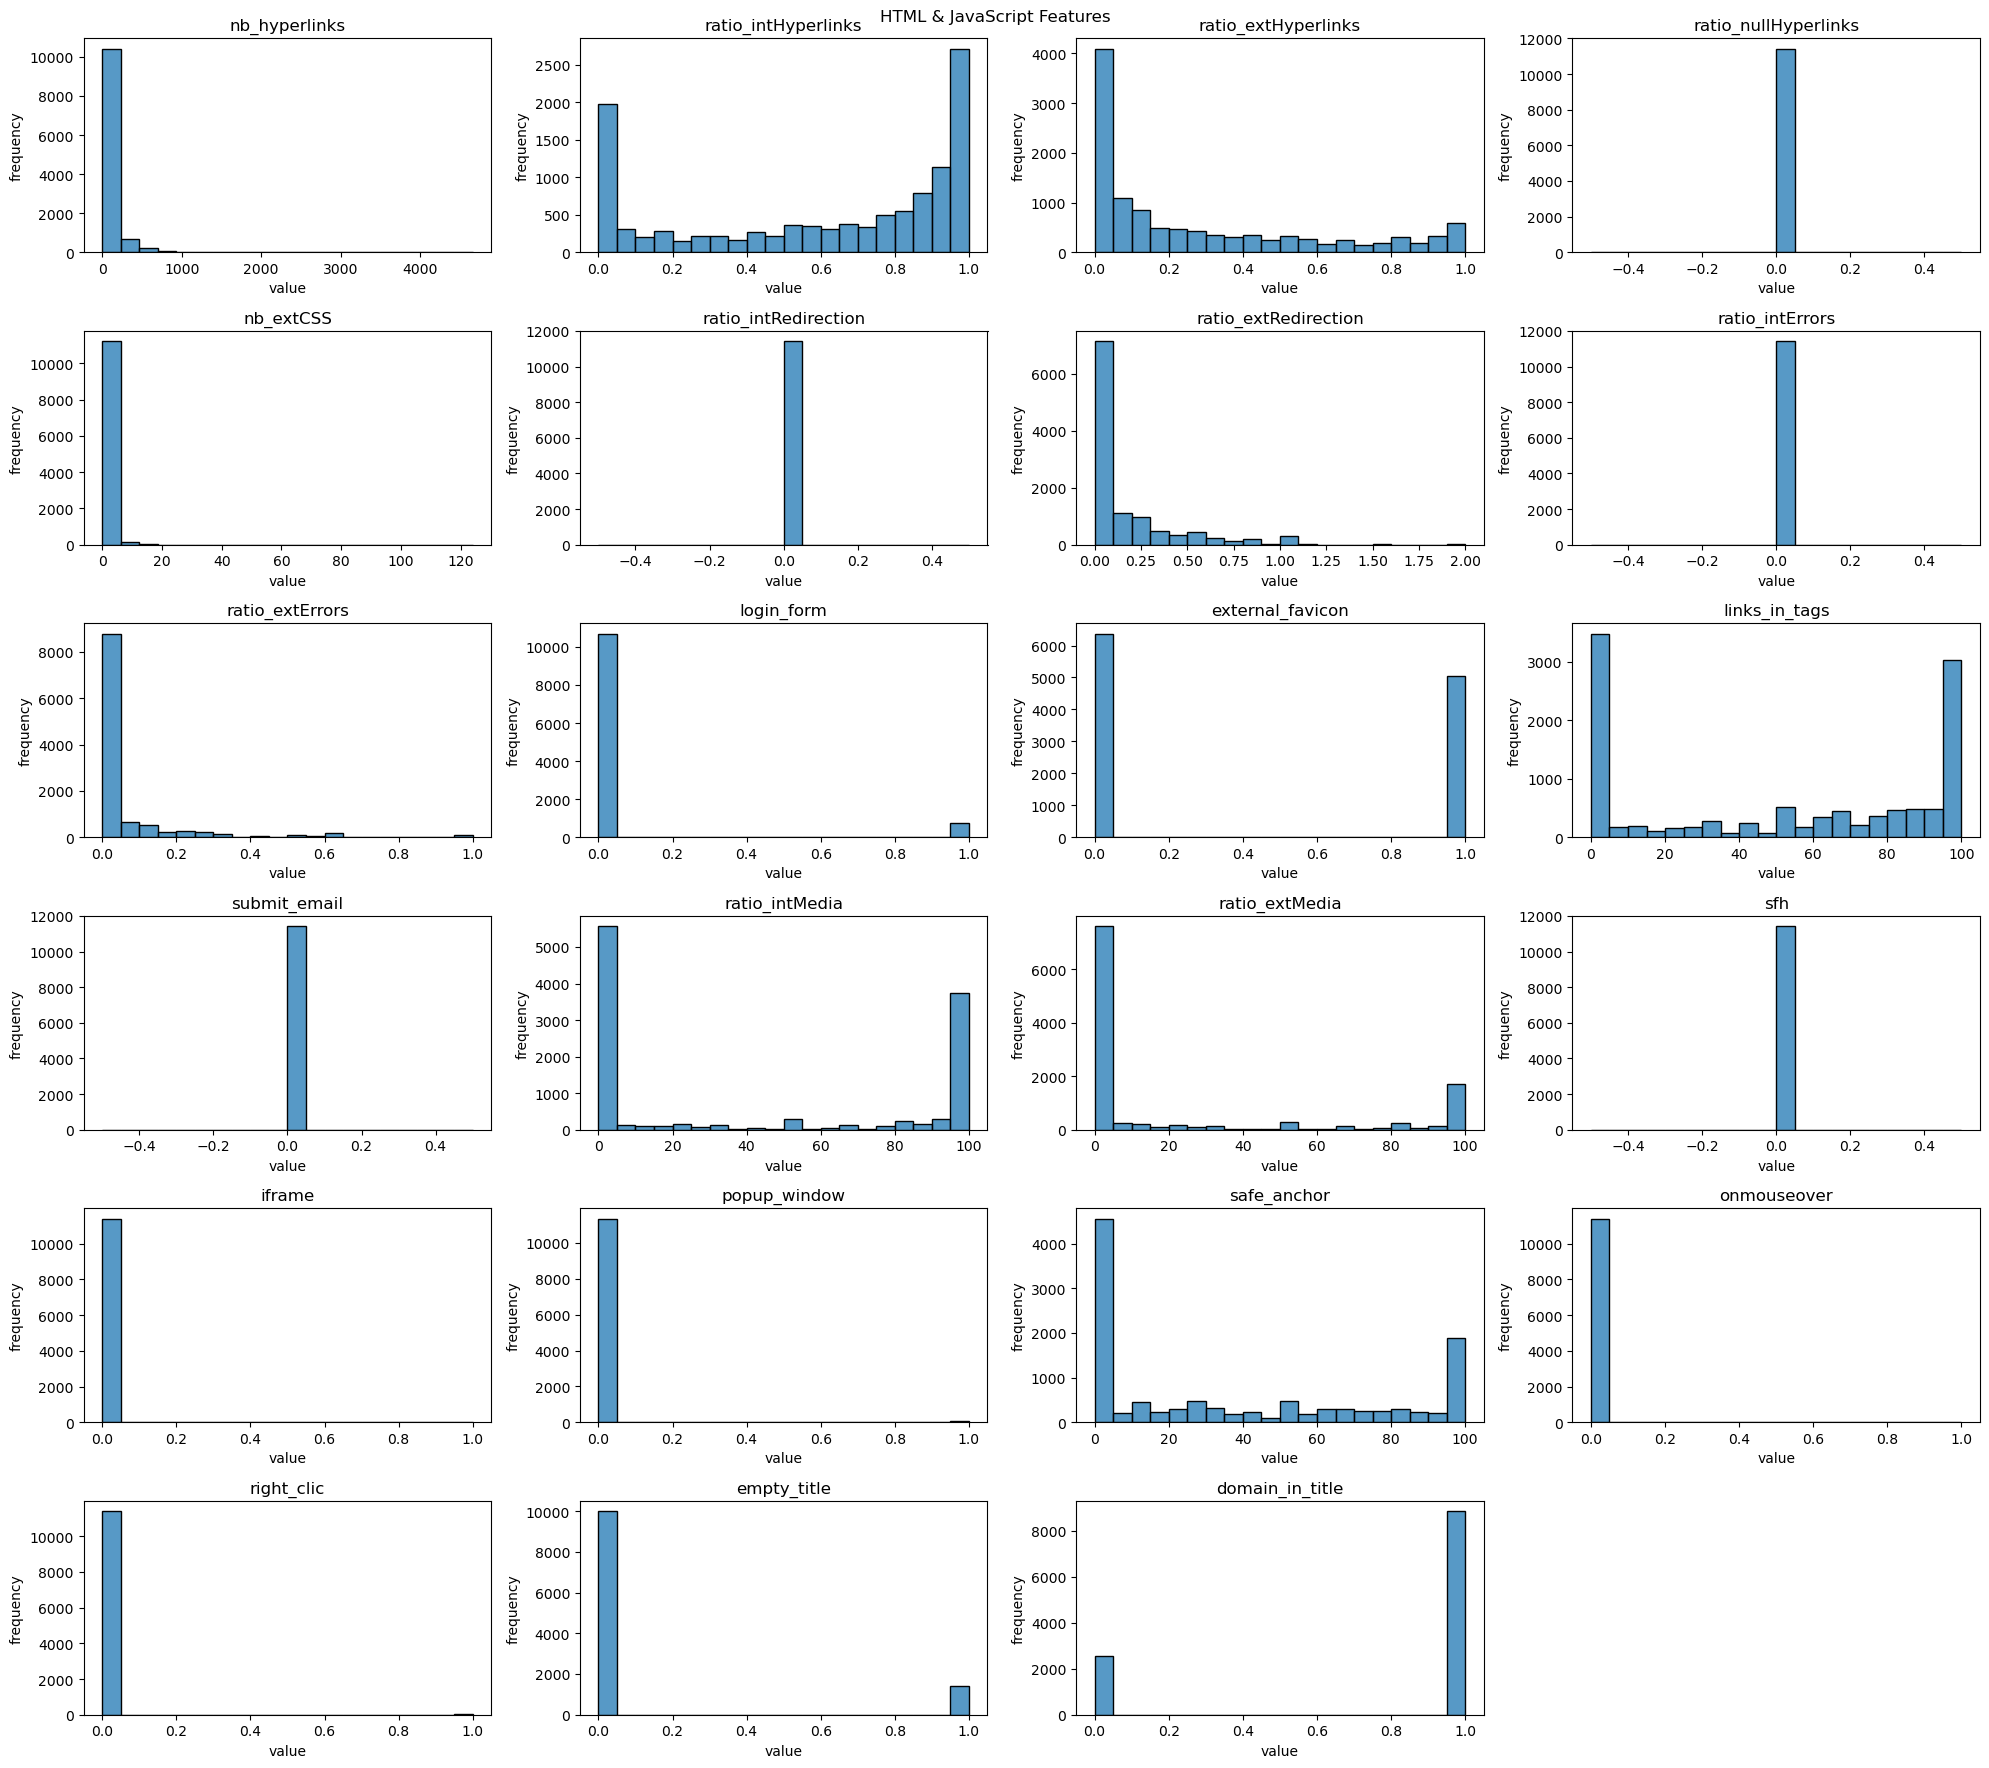

In [22]:
js_features = [
    'nb_hyperlinks',
    'ratio_intHyperlinks',
    'ratio_extHyperlinks',
    'ratio_nullHyperlinks',
    'nb_extCSS',
    'ratio_intRedirection',
    'ratio_extRedirection',
    'ratio_intErrors',
    'ratio_extErrors',
    'login_form',
    'external_favicon',
    'links_in_tags',
    'submit_email',
    'ratio_intMedia',
    'ratio_extMedia',
    'sfh',
    'iframe',
    'popup_window',
    'safe_anchor',
    'onmouseover',
    'right_clic',
    'empty_title',
    'domain_in_title'
]

plot_features(df_raw, js_features, "HTML & JavaScript Features")

### WHOIS Features - derived from domain registration data
- `whois_registered_domain`: 1 if WHOIS data is available for the domain, 0 if not (missing WHOIS is suspicious).
- `domain_registration_length`: Number of days the domain is registered for (longer = more likely to be legitimate).
- `domain_age`: Age of the domain in days (newly registered domains are common in phishing).

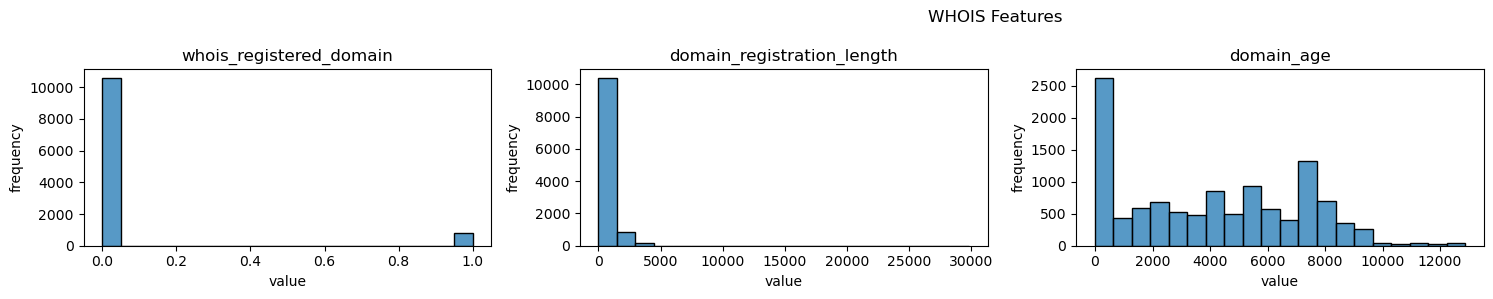

In [24]:
whois_features = [
    'whois_registered_domain',
    'domain_registration_length',
    'domain_age'
]

plot_features(df_raw, whois_features, "WHOIS Features")

### Search Engine Optimization (SEO) Features - online reputation and discoverability of the website
- `web_traffic`: Estimated amount of traffic the website gets (e.g., from Alexa rank); low traffic can be suspicious.
- `dns_record`: 1 if the domain has valid DNS records; 0 if not.
- `google_index`: 1 if the site is indexed by Google, 0 if not (phishing sites often are not).
- `page_rank`: An SEO-based score from 0 to 10; higher scores mean more authoritative/trusted sites.
- `domain_with_copyright`: 1 if the domain has copyright meta information, indicating professionalism or legitimacy.


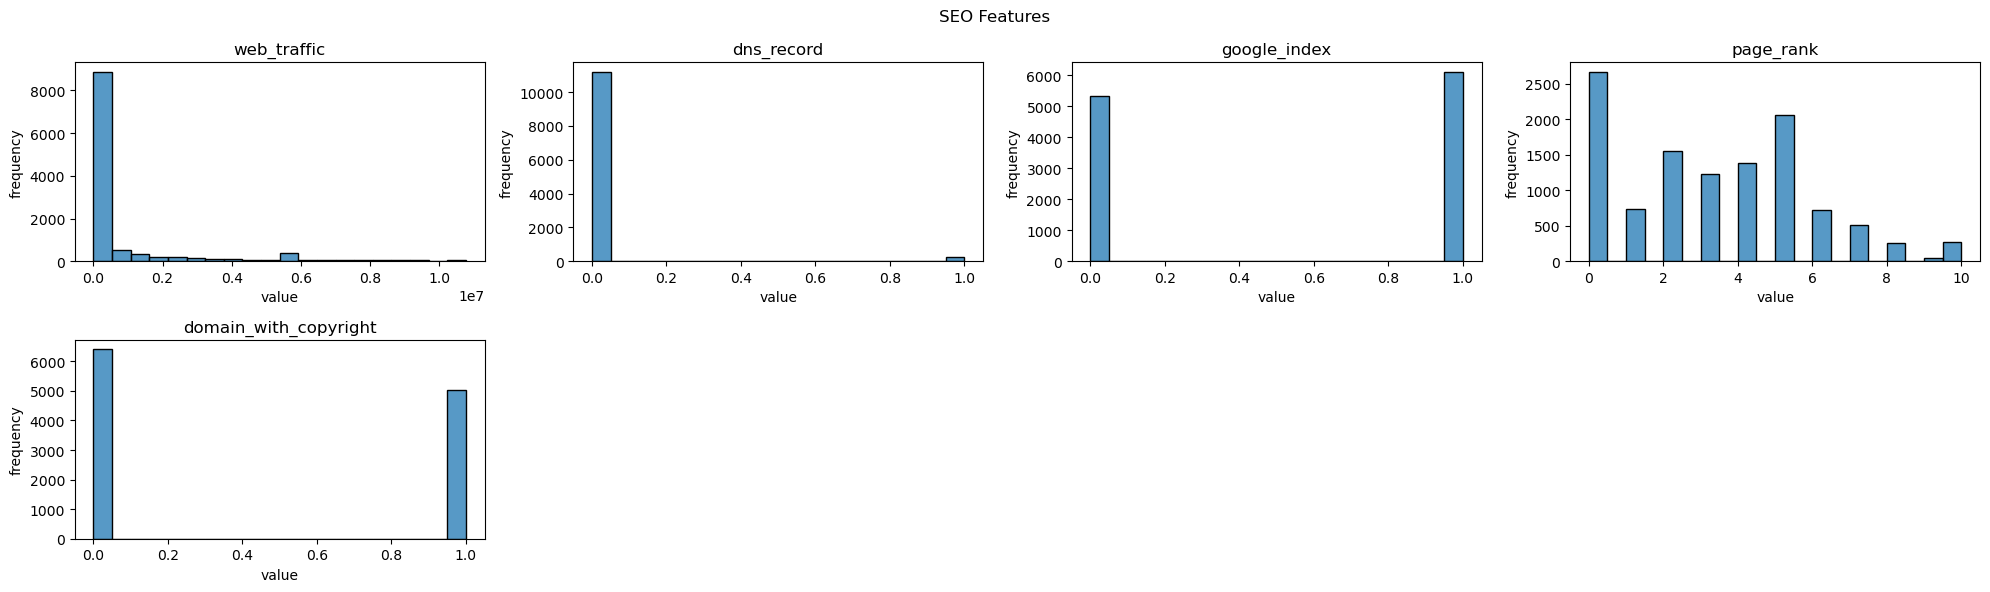

In [26]:
seo_features = [
    'web_traffic',
    'dns_record',
    'google_index',
    'page_rank',
    'domain_with_copyright'
]

plot_features(df_raw, seo_features, "SEO Features")

### Target Variable
- `status`: Classification label — `phishing` or `legitimate`.


Text(0.5, 1.0, 'Class Distribution')

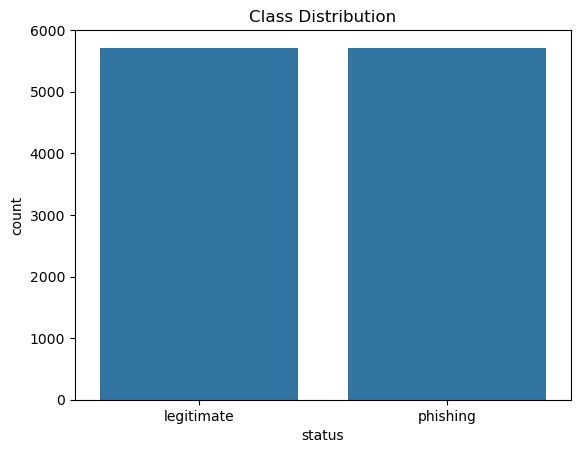

In [28]:
# check target distribution
sns.countplot(x='status', data=df_raw)
plt.title("Class Distribution")

### Correlation Matrix
Identify the top 10 features most strongly correlated with the target variable.

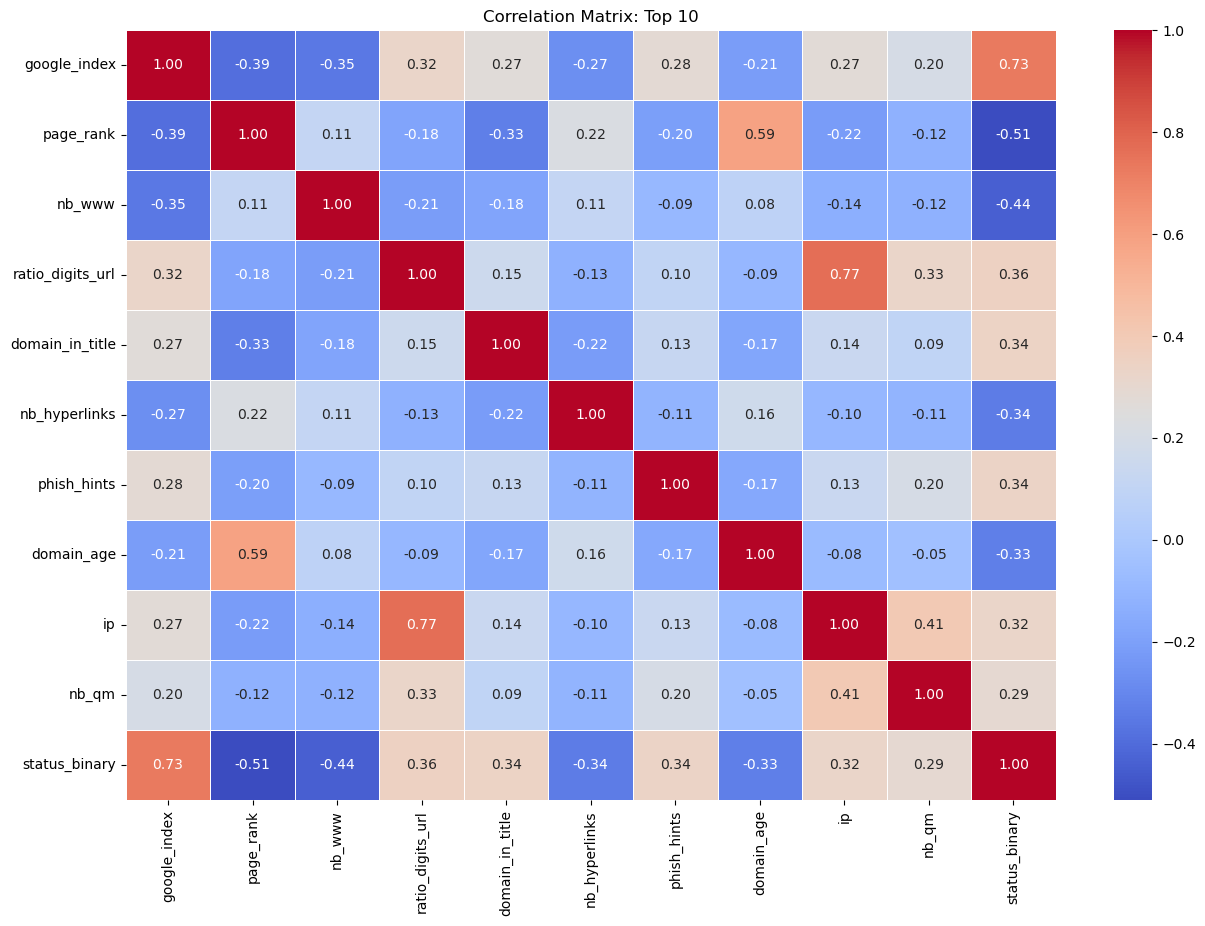

In [30]:
# turn target into numeric
df_raw['status_binary'] = df_raw['status'].apply(lambda x: 1 if x == 'phishing' else 0)

# get correlations with the target variable only
target_corr = df_raw.corr(numeric_only=True)['status_binary'].drop('status_binary')

# get top 10 features most correlated with the target
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# correlation matrix for just those 10 features + target
top10_corr_matrix = df_raw[top10_features + ['status_binary']].corr()

# plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(top10_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Top 10")
plt.show()

### Boxplot

Analyze the top 10 features most correlated with the target variable to understand their relationship and distribution across classes.

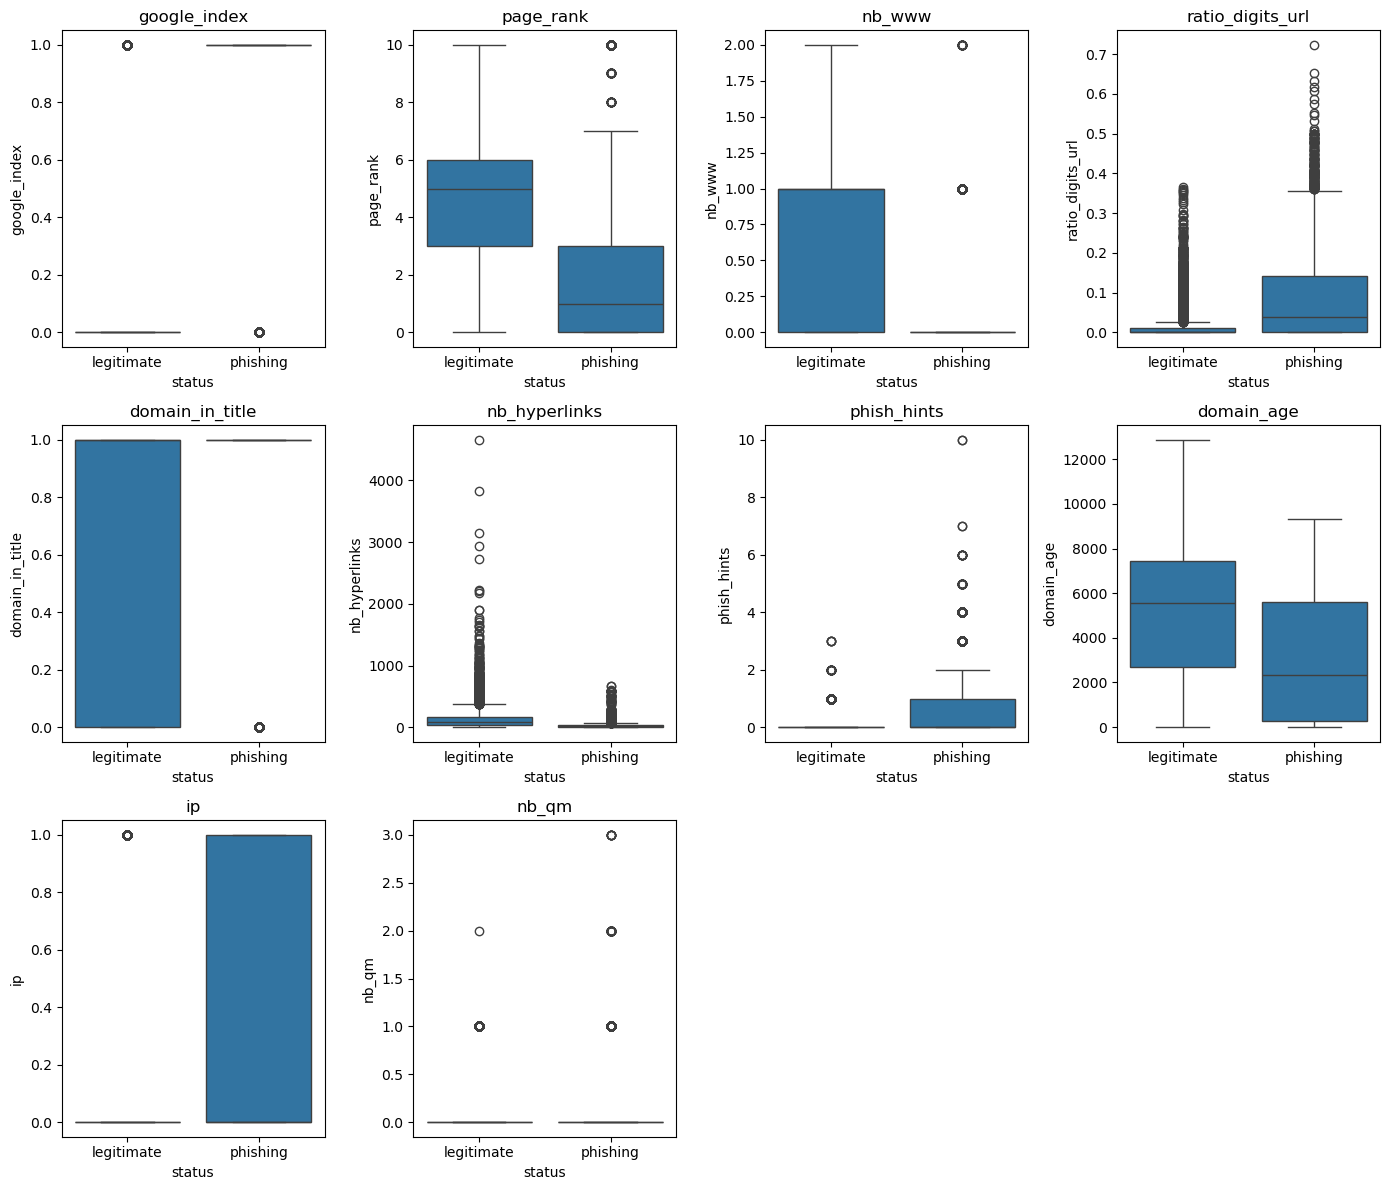

In [32]:
# dynamic rows/columns
n_cols = 4
n_rows = (len(top10_features) + n_cols - 1) // n_cols

# create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

# plot boxplots for each selected feature
for i, feature in enumerate(top10_features):
    sns.boxplot(data=df_raw, x='status', y=feature, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_ylabel(feature)

# remove the unused subplot if needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 5. Machine Learning (ML) Models  
In this section, we train and evaluate various traditional ML models to predict the target variables (status: phishing or legitimate).  

### Steps:  
- **Data Preparation:** Identifying target variables.  
- **Data Splitting:** Dividing the data into training (80%) and testing (20%) sets.  
- **Model Training:** Training traditional ML. 
- **Model Evaluation:** Models are tested against the test dataset, comparing results using metrics such as **MSE, RMSE, and R-square scores**.  


# 6. Model Deployment  

In this section, we outline the strategy for deploying the machine learning model into a production environment.

# 7. Conclusion

----------------
$^{1}$ Hannousse, A., & Yahiouche, S. (2021). Web page phishing detection (Version 3) [Data set]. Mendeley Data. https://doi.org/10.17632/c2gw7fy2j4.3